# Генератор случайных чисел
## Офисные часы 1
### Кирилл Перминов

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
np.random.seed(seed=1)

## Доверительные интервалы

Пусть $x_1, \ldots, x_n \sim \mathcal{N}(\mu, \sigma^2) $, и параметры $\mu$, $\sigma^2$ являются неизвестными.

Построим 95\%-доверительный интервал для $\mu$.

Будем использовать следующие две статистики:
$$ \bar{x} = \frac{x_1+\ldots+x_n}{n}, \quad S_x^2 = \frac{(x_1-\bar{x})^2+\ldots+(x_n-\bar{x})^2}{n-1} $$

Их распределения:
$$ \frac{\bar{x} - \mu}{\sigma/\sqrt{n}} \sim \mathcal{N}(0, 1), \quad \frac{(n-1)S_x^2}{\sigma^2} \sim \chi^2(n-1) $$

Кроме того, из леммы Фишера известно, что $\bar{x}$ и $S_x^2$ независимы. Поэтому:

$$ \frac{\bar{x} - \mu}{S_x / \sqrt{n}} = \frac{\frac{\bar{x}-\mu}{\sigma/\sqrt{n}}}{S_x/\sigma} \sim \frac{\mathcal{N}(0, 1)}{\sqrt{\frac{\chi^2(n-1)}{n-1}}} = t(n-1) $$

Построим доверительный интервал, опираясь на распределение величины $\frac{\bar{x} - \mu}{S_x / \sqrt{n}}$:

$$ P\left(-t_{\alpha/2}(n-1) < \frac{\bar{x} - \mu}{S_x / \sqrt{n}} < t_{\alpha/2}(n-1) \right) = 1-\alpha $$

Осталось записать неравенства так, чтобы получился интервал для $\mu$:

$$ P\left( \bar{x} - \frac{S_x}{\sqrt{n}} t_{\alpha/2}(n-1) < \mu < \bar{x} + \frac{S_x}{\sqrt{n}} t_{\alpha/2}(n-1) \right) = 1 - \alpha $$

Запустим несколько экспериментов, в каждом из которых сгенерируем выборку из $n$ элементов и получим доверительный интервал.

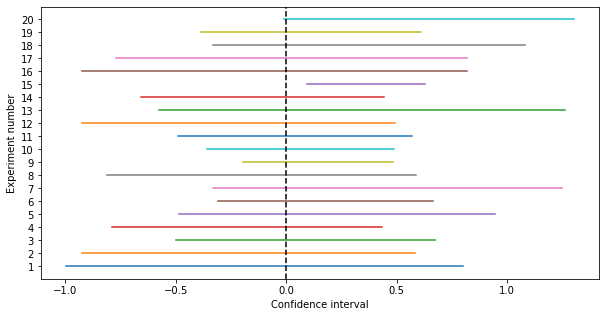

Интервал накрыл число mu в 95.03% экспериментов


In [3]:
mu = 0 # Ненаблюдаемое значение mu
sigma = 1 # Ненаблюдаемое значение sigma
alpha = 0.05 # 1 - (уровень доверия)
N_exp = 1000000 # Количество экспериментов
n = 10 # Размер выборки в каждом эксперименте
x = scipy.stats.norm(loc=mu, scale=sigma).rvs((N_exp, n))
x_mean = np.mean(x, axis=1)
Sx = np.std(x, ddof=1, axis=1)
tcoef = scipy.stats.t(n - 1).ppf(1 - alpha / 2)
confint_left = x_mean - Sx * tcoef / np.sqrt(n)
confint_right = x_mean + Sx * tcoef / np.sqrt(n)
is_covered = (confint_left < mu) & (mu < confint_right)

N_show = 20
plt.figure(figsize=(10, 5))
for i in range(N_show):
    plt.plot([confint_left[i], confint_right[i]], [i + 1] * 2)
plt.axvline(mu, color="black", linestyle="dashed")
plt.xlabel("Confidence interval")
plt.ylabel("Experiment number")
plt.yticks(np.arange(N_show) + 1)
plt.show()
print(f"Интервал накрыл число mu в {(np.mean(is_covered) * 100):.2f}% экспериментов")

## Тестирование гипотез

Имеется две гипотезы:
$$ H_0: \mu = 0, \quad H_1: \mu \neq 0 $$

В условиях $H_0$:
$$ P\left(\left.-t_{\alpha/2}(n-1) < \frac{\bar{x} - 0}{S_x / \sqrt{n}} < t_{\alpha/2}(n-1) \right| H_0\right) = 1-\alpha $$
$$ P\left(\left.\frac{|\bar{x}|}{S_x / \sqrt{n}} < t_{\alpha/2}(n-1) \right| H_0\right) = 1-\alpha $$

Будем отвергать гипотезу $H_0$, если $\frac{|\bar{x}|}{S_x / \sqrt{n}} > t_{\alpha/2}(n-1)$.

Иными словами, отвергаем $H_0$, если доверительный интервал не накрыл число 0.

In [4]:
rejected = (confint_left > 0) | (confint_right < 0)
print(f"Гипотеза H0 была отвергнута в {(np.mean(rejected) * 100):.2f}% экспериментов")

Гипотеза H0 была отвергнута в 4.97% экспериментов


## p-value

Гипотеза $H_0: \mu = 0$ отвергается, если $\frac{|\bar{x}|}{S_x / \sqrt{n}} > t_{\alpha/2}(n-1)$. Получим неравенство на $\alpha$:
$$ F_{t(n-1)}\left( \frac{|\bar{x}|}{S_x / \sqrt{n}} \right) > 1 - \frac{\alpha}{2} $$
$$ \alpha > 2 \left(1 - F_{t(n-1)}\left( \frac{|\bar{x}|}{S_x / \sqrt{n}} \right)\right) $$

То есть, мы отвергаем $H_0$, если выбранный нами уровень значимости $\alpha$ (вероятность ошибки первого рода) достаточно большой. Порог на $\alpha$:

$$ \text{$p$-value} = 2 \left(1 - F_{t(n-1)}\left( \frac{|\bar{x}|}{S_x / \sqrt{n}} \right)\right) $$

В каждом эксперименте получается своё $p$-value. Построим гистограмму распределения $p$-value.

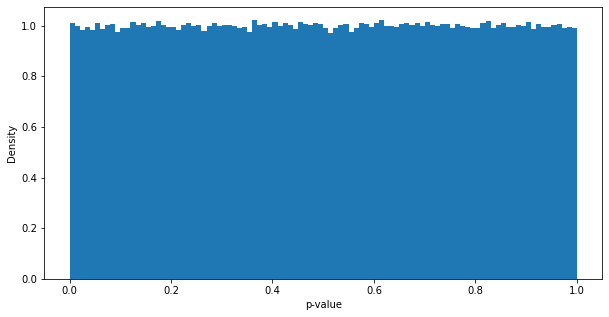

In [5]:
pvalue = 2 * (1 - scipy.stats.t(n-1).cdf(np.abs(x_mean) / (Sx / np.sqrt(n))))

plt.figure(figsize=(10, 5))
plt.hist(pvalue, density=True, bins=np.linspace(0, 1, 101))
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

Если гипотеза $H_0$ верна, то $p$-value распределено равномерно на отрезке $[0, 1]$.

Если же гипотеза $H_0$ не верна, то $p$-value сконцентрированно около 0.

# p-hacking

Покажем одну из уязвимостей $p$-value.

Пусть гипотеза $H_0$ верна. Тем не менее, экспериментатор хочет получить $p$-value меньше 0.05, чтобы опубликовать исследование.

И пусть он может сделать любое количество наблюдений $n$ от 100 до 200.

Если выбрать $n$ заранее (например, $n = 150$), то $p$-value окажется меньше 0.05 с вероятностью 0.05.

Поэтому экспериментатор идёт на хитрость: он пересчитывает $p$-value после каждого нового наблюдения. И останавливается в первый же момент, как только $p$-value оказалось меньше 0.05. Заметим, что в своём отчёте он сможет честно указать обо всех наблюдениях, без каких-либо фальсификаций.

Проведём такой эксперимент много раз и визуализируем первые 5 из них: построим зависимость $p$-value от количества сделанных наблюдений.

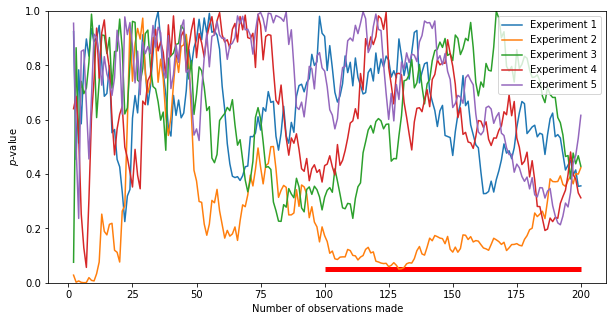

p-value < 0.05 в 15.72% экспериментов


In [6]:
mu = 0
sigma = 1
alpha = 0.05
n_min = 100
n_max = 200
N_exp = 10000
x = scipy.stats.norm(loc=mu, scale=sigma).rvs((N_exp, n_max))
n = np.arange(2, n_max + 1)[np.newaxis, :]
x_mean = np.cumsum(x, axis=1)[:, 1:] / n
xx_mean = np.cumsum(x * x, axis=1)[:, 1:] / n
Sx = np.sqrt(xx_mean - x_mean ** 2) * np.sqrt(n / (n - 1))
tstat = np.abs(x_mean) / (Sx / np.sqrt(n))
pvalue = 2 * (1 - scipy.stats.t.cdf(tstat, df=n))

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(n[0], pvalue[i], label=f"Experiment {i + 1}")
plt.hlines(alpha, n_min, n_max, color="red", linewidth=5)
plt.ylim(bottom=0, top=1)
plt.legend()
plt.xlabel("Number of observations made")
plt.ylabel("$p$-value")
plt.show()
print(f"p-value < 0.05 в {(np.mean(np.any((pvalue < 0.05) & (n >= n_min), axis=1)) * 100):.2f}% экспериментов")